In [25]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gmean


In [33]:
base_dir = "../logs/COMP/"
# Define trace names and configuration labels
trace_names = ['450.soplex-247B', '471.omnetpp-188B', '623.xalancbmk_s-10B', '602.gcc_s-2226B']
configs = ['ipcp', 'isb' ,'ipcp_isbv2-all', 'ipcp_isbv2-default', 'ipcp_isbv2-exclusive', 'ipcp_isbv2-with-GS', 'ipcp_isbv2-with-CS', 'ipcp_isbv2-with-CPLX']

# Initialize a dictionary to store IPC values for each trace and configuration
ipc_values = {trace: {} for trace in trace_names}


In [34]:
ipc_values

{'450.soplex-247B': {},
 '471.omnetpp-188B': {},
 '623.xalancbmk_s-10B': {},
 '602.gcc_s-2226B': {}}

In [35]:
def extract_ipc(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'CPU 0 cumulative IPC' in line:  # Assuming the line with IPC contains the keyword 'IPC'
                ipc_value = float(re.search(r"IPC:\s([\d\.]+)", line).group(1))
                return ipc_value
    return None

# Parse the IPC values from the log files
for trace in trace_names:
    for config in configs:
        log_file = base_dir + f"{trace}-{config}.log"
        ipc_values[trace][config] = extract_ipc(log_file)


In [36]:
ipc_values['450.soplex-247B']['baseline'] = 0.26592
ipc_values['471.omnetpp-188B']['baseline'] = 0.225573
ipc_values['602.gcc_s-2226B']['baseline'] = 0.0980601
ipc_values['623.xalancbmk_s-10B']['baseline'] = 0.238761

In [37]:
# Calculate speedups relative to the baseline
speedups = {trace: {} for trace in trace_names}

for trace in trace_names:
    baseline_ipc = ipc_values[trace]['baseline']
    for config in configs:  # Skip baseline
        speedups[trace][config] = ipc_values[trace][config] / baseline_ipc
# Calculate geometric mean for each configuration (excluding baseline)
geomeans = {}
for config in configs:
    config_speedups = [speedups[trace][config] for trace in trace_names]
    geomeans[config] = gmean(config_speedups)  # Use scipy's gmean for geometric mean

speedups['Geomean'] = geomeans
trace_names += ['Geomean']

In [38]:
speedups

{'450.soplex-247B': {'ipcp': 1.3543471720818292,
  'isb': 1.4130678399518652,
  'ipcp_isbv2-all': 1.5078707882069797,
  'ipcp_isbv2-default': 1.5073029482551143,
  'ipcp_isbv2-exclusive': 1.431159747292419,
  'ipcp_isbv2-with-GS': 1.5078707882069797,
  'ipcp_isbv2-with-CS': 1.439778880866426,
  'ipcp_isbv2-with-CPLX': 1.4956528279181711},
 '471.omnetpp-188B': {'ipcp': 1.0313069383303854,
  'isb': 1.3000802400996574,
  'ipcp_isbv2-all': 1.0875193396372793,
  'ipcp_isbv2-default': 1.087980387723708,
  'ipcp_isbv2-exclusive': 1.034095392622344,
  'ipcp_isbv2-with-GS': 1.088042451889189,
  'ipcp_isbv2-with-CS': 1.0337850717949402,
  'ipcp_isbv2-with-CPLX': 1.088002553497094},
 '623.xalancbmk_s-10B': {'ipcp': 1.1042213761879034,
  'isb': 1.2326845674126008,
  'ipcp_isbv2-all': 1.2859386583235957,
  'ipcp_isbv2-default': 1.2867428097553621,
  'ipcp_isbv2-exclusive': 1.1161538107144802,
  'ipcp_isbv2-with-GS': 1.2871030025841743,
  'ipcp_isbv2-with-CS': 1.107710220680932,
  'ipcp_isbv2-with-C

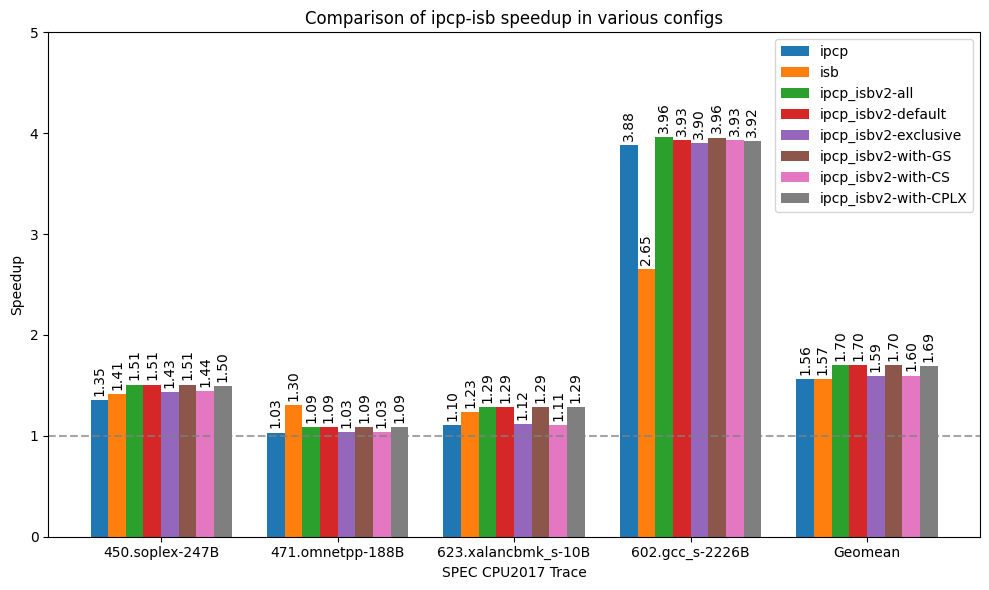

In [46]:
# Plotting the speedups
plt.rcParams.update({'font.size': 10})
x = np.arange(len(trace_names))  # X axis positions for the traces
width = 0.1  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each configuration
for i, config in enumerate(configs):  # Skip baseline
    speedup_values = [speedups[trace][config] for trace in trace_names]
    bars = ax.bar(x + i*width, speedup_values, width, label=config)
    
    # Annotate bars with speedup values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

# Add a translucent dashed line at y=1.0 for the baseline
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)


# Add labels and titles
ax.set_xlabel('SPEC CPU2017 Trace')
ax.set_ylim(0, 5.0)
ax.set_ylabel('Speedup')
ax.set_title('Comparison of ipcp-isb speedup in various configs')
ax.set_xticks(x + 7*width / 2)
ax.set_xticklabels(trace_names, rotation=0)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
